# Dog Identification (2 - Build and Validating a Model)

The task here is to develop and train a CNN algorthim that, given an image of a dog, identifes its breed. If supplied an image of a human, the code will identify the resembling dog breed.

After a custom classifier has been built I'll load in a pre-trained classifier to compare.

At the end of this notebook we'll feed human and go images into the algorithm.

## Create a custom CNN

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images. 

First we will create a custom CNN from srcatch and after we'll use a transfer learning on a pretrained model to compare the accuracy.

### Import Libraries

In [1]:
!pip install --upgrade pip
!pip install opencv-python

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages (20.0.2)


In [2]:
import os
import cv2
import numpy as np
from glob import glob

import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.autograd import Variable
import random

from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

%matplotlib inline

In [3]:
#Check if gpu support is available
use_cuda = torch.cuda.is_available()

### Preprocessing

In [4]:
# Use standard Normalisation Values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

std_norm = transforms.Normalize(mean, std)

In [5]:
# data transformations
data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                                std_norm]),
                   
                   'valid': transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     std_norm]),
                   
                   'test': transforms.Compose([transforms.Resize(size=(224,224)),
                                     transforms.ToTensor(), 
                                     std_norm])
                  }

In [6]:
batch_size = 64
num_workers = 0

data_dir = "dog_images"

# transform the data
img_data = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'valid', 'test']}

# load the dataset
data_loader = {x: torch.utils.data.DataLoader(img_data[x],
                                             batch_size = batch_size,
                                             shuffle = True,
                                             num_workers = num_workers)
              for x in ['train', 'valid', 'test']}

dataset_size = {x: len(img_data[x]) for x in ['train', 'valid', 'test']}

class_names = img_data['train'].classes
n_classes = len(class_names)

In [7]:
# print statistics about the dataset
print(f"No. of Training Images: {dataset_size['train']}")
print(f"No. of Validation Images: {dataset_size['valid']}")
print(f"No. of Testing Images: {dataset_size['test']}")      
print(f"No. of Classes: {n_classes}")

No. of Training Images: 6680
No. of Validation Images: 835
No. of Testing Images: 836
No. of Classes: 133


### Display Processed Images

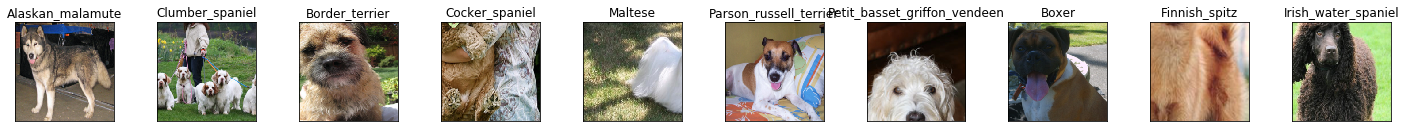

In [8]:
def imshow(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)    
    plt.imshow(inp)
    
# Get a batch of training data
images, classes = next(iter(data_loader['train']))
      
fig = plt.figure(figsize=(25,4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(class_names[classes[idx]].split(".")[1])

### Model Training and Validation

Import custom model from file

In [9]:
from source_pytorch.model import Net 

custom_model = Net(n_classes)

# move tensors to GPU if CUDA is available
if use_cuda:
    custom_model.cuda()

In [10]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent)
optimizer = optim.SGD(custom_model.parameters(), lr=0.001)

In [11]:
%time
from source_pytorch.train import train

# number of epochs
epochs = 25

# train the model
model_scratch = train(epochs, data_loader, custom_model, criterion, optimizer, use_cuda, 'saved_models/model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('saved_models/model_scratch.pt'))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.44 µs
Epoch: 1 	Training Loss: 4.891046 	Validation Loss: 4.887164
Validation loss decreased (inf --> 4.887164).  Saving model ...
Epoch: 2 	Training Loss: 4.890844 	Validation Loss: 4.890230
Epoch: 3 	Training Loss: 4.889147 	Validation Loss: 4.888782
Epoch: 4 	Training Loss: 4.888687 	Validation Loss: 4.887532
Epoch: 5 	Training Loss: 4.888594 	Validation Loss: 4.889429
Epoch: 6 	Training Loss: 4.886775 	Validation Loss: 4.887087
Validation loss decreased (4.887164 --> 4.887087).  Saving model ...
Epoch: 7 	Training Loss: 4.886722 	Validation Loss: 4.885220
Validation loss decreased (4.887087 --> 4.885220).  Saving model ...
Epoch: 8 	Training Loss: 4.885919 	Validation Loss: 4.885635
Epoch: 9 	Training Loss: 4.884786 	Validation Loss: 4.883601
Validation loss decreased (4.885220 --> 4.883601).  Saving model ...
Epoch: 10 	Training Loss: 4.884757 	Validation Loss: 4.882302
Validation loss decreased (4.883601 --> 4.882302).  Sa

<All keys matched successfully>

### Test the Model

In [12]:
from source_pytorch.test import test

# call test function    
test(data_loader, model_scratch, criterion, use_cuda)

Test Loss: 4.861254


Test Accuracy:  1% ( 9/836)


___
## Create a CNN using Transfer Learning

Import a transfer learning model to create a CNN to classify dog breed.

In [13]:
#******* load the VGG16 model
vgg16 = models.vgg16(pretrained=True)
print(vgg16)

print(vgg16.classifier[6].in_features) 
print(vgg16.classifier[6].out_features)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
# Freeze training for all "features" layer
for param in vgg16.parameters():
    param.requires_grad = False

In [15]:
# Final Classifier Layer
    
n_inputs = vgg16.classifier[6].in_features
last_layer = nn.Linear(n_inputs, n_classes)

vgg16.classifier[6] = last_layer

In [16]:
# check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)
#print(vgg16)

133


In [17]:
# if GPU is available, move the model to GPU
if use_cuda:
    vgg16.cuda()

### Train and Validate Transfer Learning Model

In [18]:
%time

n_epochs = 25

# specify optimizer (stochastic gradient descent)
optimizer_tl = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

# train the transfer learning model
model_tl = train(n_epochs, data_loader, vgg16, criterion, optimizer_tl, use_cuda, 'saved_models/model_transfer.pt')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
Epoch: 1 	Training Loss: 4.813746 	Validation Loss: 4.320851
Validation loss decreased (inf --> 4.320851).  Saving model ...
Epoch: 2 	Training Loss: 4.281565 	Validation Loss: 3.736226
Validation loss decreased (4.320851 --> 3.736226).  Saving model ...
Epoch: 3 	Training Loss: 3.827537 	Validation Loss: 3.267025
Validation loss decreased (3.736226 --> 3.267025).  Saving model ...
Epoch: 4 	Training Loss: 3.423694 	Validation Loss: 2.954474
Validation loss decreased (3.267025 --> 2.954474).  Saving model ...
Epoch: 5 	Training Loss: 3.127284 	Validation Loss: 2.580128
Validation loss decreased (2.954474 --> 2.580128).  Saving model ...
Epoch: 6 	Training Loss: 2.876019 	Validation Loss: 2.301681
Validation loss decreased (2.580128 --> 2.301681).  Saving model ...
Epoch: 7 	Training Loss: 2.647346 	Validation Loss: 2.142580
Validation loss decreased (2.301681 --> 2.142580).  Saving model ...
Epoch: 8 	Training Loss: 2.4717

In [19]:
# load the model with the best validation accuracy
model_tl.load_state_dict(torch.load('saved_models/model_transfer.pt'))

<All keys matched successfully>

### Test the model

In [20]:
test(data_loader, model_tl, criterion, use_cuda)

Test Loss: 0.937401


Test Accuracy: 80% (673/836)


## Display the Predictions 

We'll use the VGG16 model as it was a lot more accuracte than the custom model.

In [21]:
# create a list of class names by index 
# i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in img_data['train'].classes]

In [22]:
import matplotlib.image as mpimg
from source_pytorch.helpers import predict_breed

### Display prediction
def display_predictions(img_path, model_tl, class_names, img_data, std_norm):
    #print (img_path)
    breed, name = predict_breed(img_path, model_tl, class_names, img_data, std_norm)
        
    # display test image
    fig = plt.figure(figsize=(16,4))
    ax = fig.add_subplot(1,2,1)
    img = mpimg.imread(img_path)
    ax.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted Breed: {breed}")

    # display sample of matching breed images
    subdir = '/'.join(['dog_images/valid', str(name)])
    file = random.choice(os.listdir(subdir))
    path = '/'.join([subdir, file])
    ax = fig.add_subplot(1,2,2)
    img = mpimg.imread(path)
    ax.imshow(img.squeeze(), cmap="gray", interpolation='nearest')
    plt.title(f"Actual breed: {breed}")
    plt.axis('off')
    plt.show()
     
    print("\n"*3)

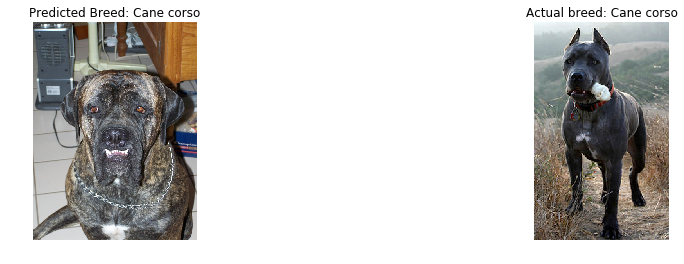

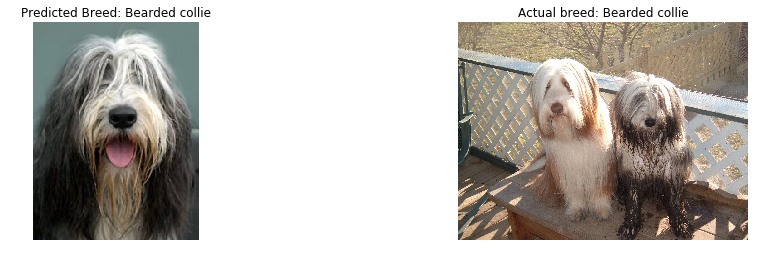

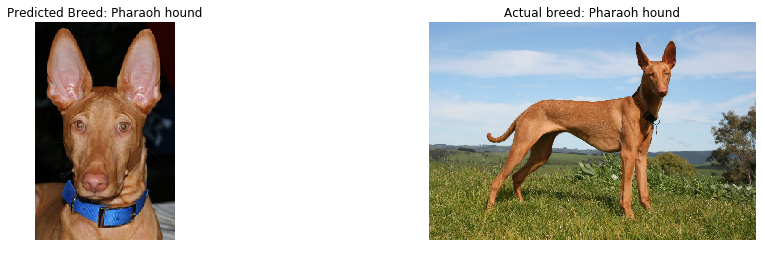

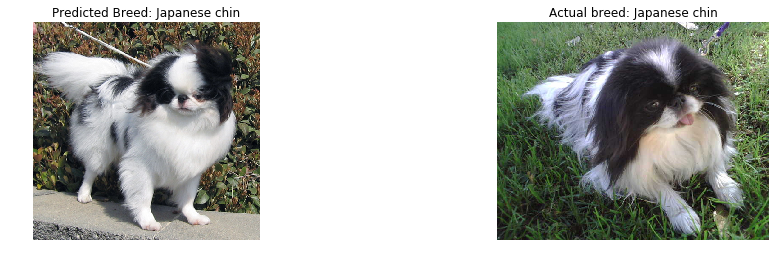

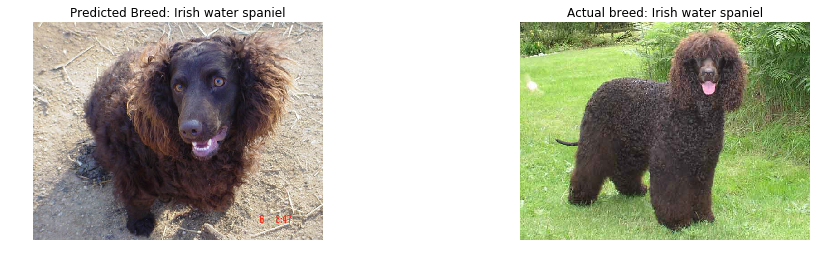

In [23]:
# Create a list of the test images
test_img_paths = sorted(glob('dog_images/test/*/*'))

# Shuffle the list and display first 5 rows
np.random.shuffle(test_img_paths)
test_img_paths[0:5]

for img_path in test_img_paths[0:5]:
    display_predictions(img_path, model_tl, class_names, img_data, std_norm)

## Dog -- Human App

Hey... What's up HUMAN?!


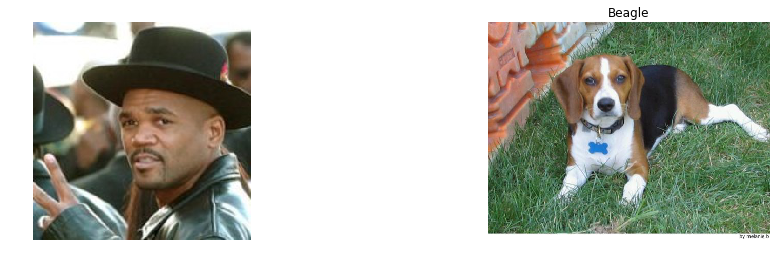

You look like ...Beagle




Hey... What's up HUMAN?!


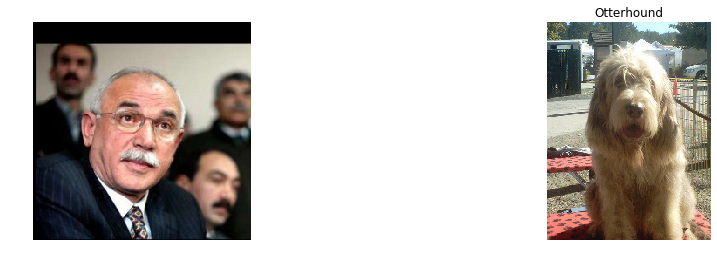

You look like ...Otterhound




Hey... What's up HUMAN?!


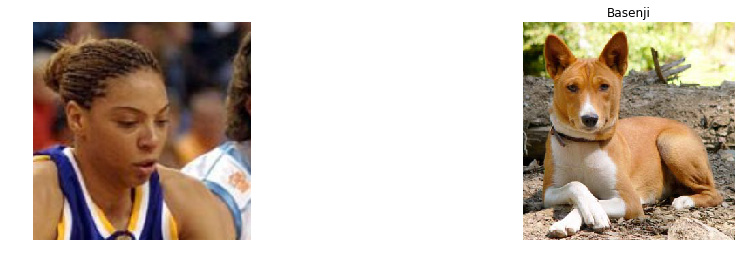

You look like ...Basenji




Hey... What's up DOG?!


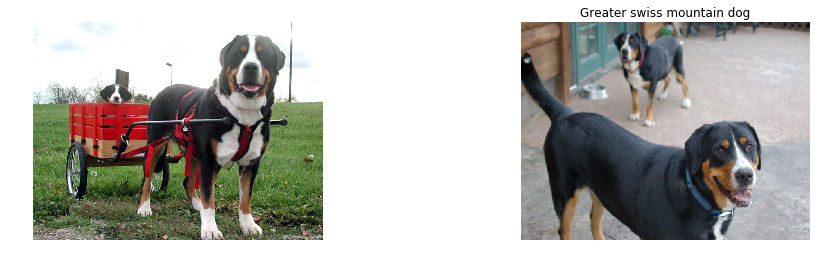

You look like ... Greater swiss mountain dog




Hey... What's up DOG?!


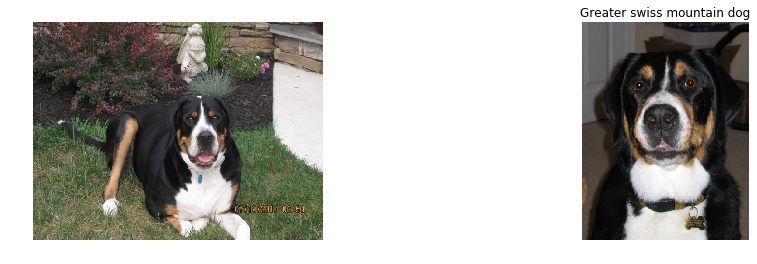

You look like ... Greater swiss mountain dog




Hey... What's up DOG?!


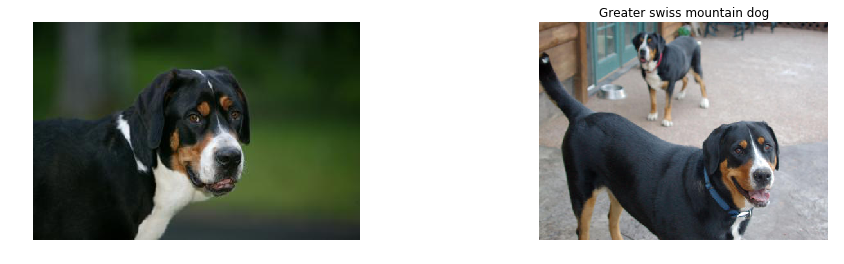

You look like ... Greater swiss mountain dog






In [24]:
from source_pytorch.dog_app import main_detector

human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dog_images/*/*/*"))

for file in np.hstack((human_files[3:6], dog_files[3:6])):
    main_detector(file, model_tl, class_names, img_data, std_norm)
    

There are 8 total test images
Hey... What's up HUMAN?!


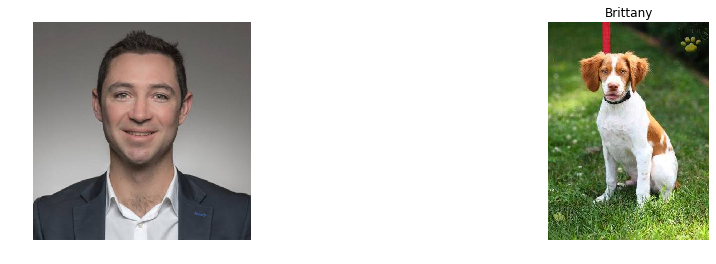

You look like ...Brittany




I can't determine what you are!


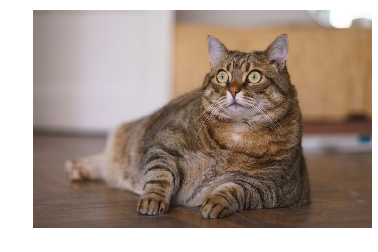





I can't determine what you are!


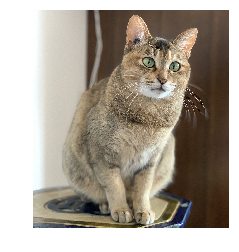





Hey... What's up HUMAN?!


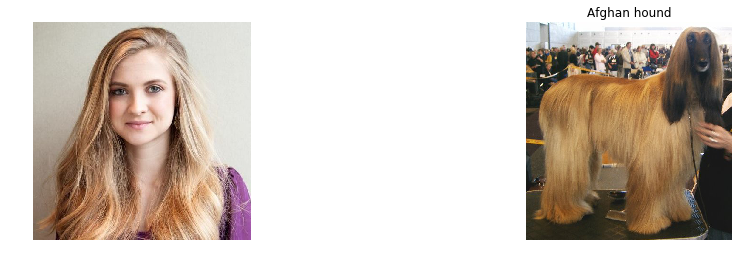

You look like ...Afghan hound




Hey... What's up DOG?!


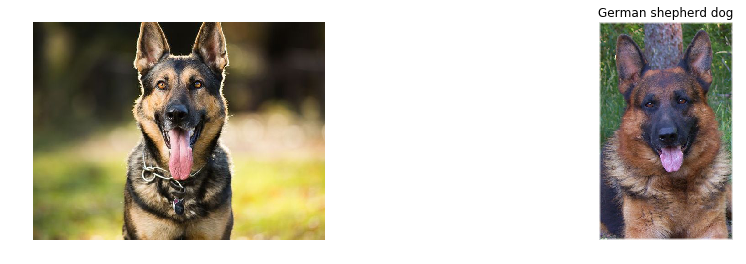

You look like ... German shepherd dog




Hey... What's up DOG?!


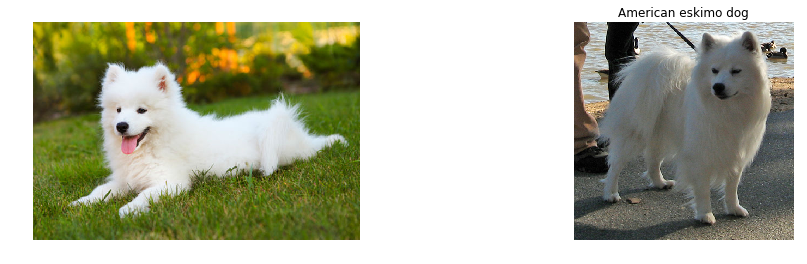

You look like ... American eskimo dog




Hey... What's up DOG?!


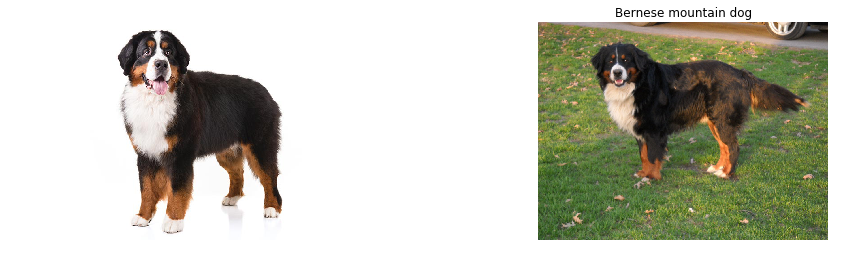

You look like ... Bernese mountain dog




Hey... What's up HUMAN?!


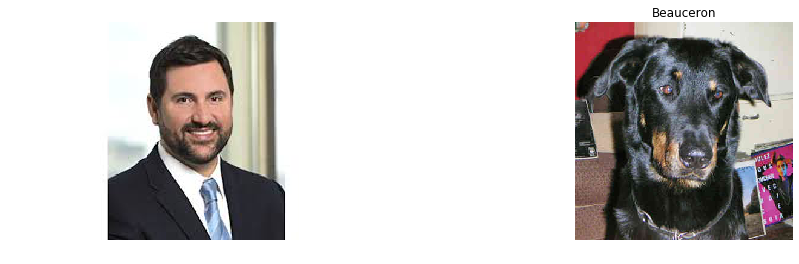

You look like ...Beauceron






In [26]:
# Test algorithm on images provided in '/images' directory. Make predictions for each image. And show an example 
#  for each prediction.

test_files = np.array(glob("test_images/*"))

# print number of images in each dataset
print('There are %d total test images' % len(test_files))

for file in np.hstack((test_files[:])):
    main_detector(file, model_tl, class_names, img_data, std_norm)